# Yelp API - Lab


## Introduction 

Now that we've seen how the Yelp API works and some basic Folium visualizations, it's time to put those skills to work in order to create a working map! Taking things a step further, you'll also independently explore how to perform pagination in order to retrieve a full results set from the Yelp API!

## Objectives

You will be able to: 
* Create HTTP requests to get data from Yelp API
* Parse HTTP responses and perform data analysis on the data returned
* Perform pagination to retrieve troves of data!
* Create a simple geographical system on to view information about selected businesses, at a given location. 

## Problem Introduction

You've now worked with some API calls, but we have yet to see how to retrieve a more complete dataset in a programmatic manner. Returning to the Yelp API, the [documentation](https://www.yelp.com/developers/documentation/v3/business_search) also provides us details regarding the API limits. These often include details about the number of requests a user is allowed to make within a specified time limit and the maximum number of results to be returned. In this case, we are told that any request has a maximum of 50 results per request and defaults to 20. Furthermore, any search will be limited to a total of 1000 results. To retrieve all 1000 of these results, we would have to page through the results piece by piece, retrieving 50 at a time. Processes such as these are often referred to as pagination.

In this lab, you will define a search and then paginate over the results to retrieve all of the results. You'll then parse these responses as a DataFrame (for further exploration) and create a map using Folium to visualize the results geographically.

## Part I - Make the Initial Request

Start by making an initial request to the Yelp API. Your search must include at least 2 parameters: **term** and **location**. For example, you might search for pizza restaurants in NYC. The term and location is up to you, but make the request below.

In [5]:
client_id = "WksaDnsw4SSoKEBqkyUwkQ" #Your client ID goes here (as a string)
api_key = "Ie1oWbJxzj8IAn348fY_pqYlPmjgwWNcBtP793ZsHmZOfRgohOHfHf0z2JKunKwdgTU90hEYpQF32KqY3y2ck_eqHJ_TEU8YqmJwgHAWMhkpL1tcI6xuNRKusObZXHYx" #Your api key goes here (as a string)

In [6]:
import requests

In [7]:
term = 'salata'
location = 'New York NY'

url = 'https://api.yelp.com/v3/businesses/search'

headers = {
        'Authorization': 'Bearer {}'.format(api_key),
    }

url_params = {
                'term': term.replace(' ', '+'),
                'location': location.replace(' ', '+'),
            }
response = requests.get(url, headers=headers, params=url_params)
print(response)
print(type(response.text))
print(response.text[:1000])

<Response [200]>
<class 'str'>
{"businesses": [{"id": "l4fwf8VwAokv3MWT45Ab7g", "alias": "bunna-cafe-brooklyn", "name": "Bunna Cafe", "image_url": "https://s3-media4.fl.yelpcdn.com/bphoto/jGKIcCZ2lx23kKX2YRug7g/o.jpg", "is_closed": false, "url": "https://www.yelp.com/biz/bunna-cafe-brooklyn?adjust_creative=WksaDnsw4SSoKEBqkyUwkQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=WksaDnsw4SSoKEBqkyUwkQ", "review_count": 528, "categories": [{"alias": "ethiopian", "title": "Ethiopian"}, {"alias": "vegan", "title": "Vegan"}, {"alias": "african", "title": "African"}], "rating": 4.5, "coordinates": {"latitude": 40.705042, "longitude": -73.928078}, "transactions": ["delivery", "pickup"], "price": "$$", "location": {"address1": "1084 Flushing Ave", "address2": "", "address3": "", "city": "Brooklyn", "zip_code": "11237", "country": "US", "state": "NY", "display_address": ["1084 Flushing Ave", "Brooklyn, NY 11237"]}, "phone": "+13472952227", "display_phone": "(347) 295-2227", 

## Pagination

Now that you have an initial response, you can examine the contents of the json container. For example, you might start with ```response.json().keys()```. Here, you'll see a key for `'total'`, which tells you the full number of matching results given your query parameters. Write a loop (or ideally a function) which then makes successive API calls using the offset parameter to retrieve all of the results (or 5000 for a particularly large result set) for the original query. As you do this, be mindful of how you store the data. Your final goal will be to reformat the data concerning the businesses themselves into a pandas DataFrame from the json objects.

**Note: be mindful of the API rate limits. You can only make 5000 requests per day, and are also can make requests too fast. Start prototyping small before running a loop that could be faulty. You can also use time.sleep(n) to add delays. For more details see https://www.yelp.com/developers/documentation/v3/rate_limiting.**

In [8]:
response.json().keys()

dict_keys(['businesses', 'total', 'region'])

In [9]:
response.json()['total']

2000

In [10]:
businesses = dict(response.json())

In [11]:
len(businesses)

3

In [12]:
businesses.keys()

dict_keys(['businesses', 'total', 'region'])

In [13]:
len(businesses['businesses'])

20

In [14]:
import time

In [15]:
def query_yelp_businesses(search_term, search_location, api_key, offset=0, time_to_wait=5):
    term = search_term
    location = search_location

    url = 'https://api.yelp.com/v3/businesses/search'

    headers = {
            'Authorization': 'Bearer {}'.format(api_key),
        }

    url_params = {
                    'term': term.replace(' ', '+'),
                    'location': location.replace(' ', '+'),
                    'offset': offset
                }
    response = requests.get(url, headers=headers, params=url_params)
    time.sleep(time_to_wait)
    
    return response

In [16]:
response = query_yelp_businesses("salata", "Omaha NE", api_key, offset=0)
dict(response.json())['total']

74

In [17]:
response = query_yelp_businesses("salata", "Omaha NE", api_key, offset=0)
# Get the total number of responses
total = dict(response.json())['total']

offset = 0
responses = []
while offset < total:
    responses.append(query_yelp_businesses("salata", "Omaha NE", api_key, offset=offset))
    offset += 50

In [18]:
len(responses)

2

In [19]:
for response in responses:
    print(dict(response.json())['businesses'][0].keys())

dict_keys(['id', 'alias', 'name', 'image_url', 'is_closed', 'url', 'review_count', 'categories', 'rating', 'coordinates', 'transactions', 'location', 'phone', 'display_phone', 'distance'])
dict_keys(['id', 'alias', 'name', 'image_url', 'is_closed', 'url', 'review_count', 'categories', 'rating', 'coordinates', 'transactions', 'price', 'location', 'phone', 'display_phone', 'distance'])


In [20]:
for response in responses:
    json_dict = dict(response.json())
    business_list = json_dict['businesses']
    for business in business_list:
        print(f"{business['name']} {business['coordinates']} {business['location']}")

Chaikhana {'latitude': 41.280014, 'longitude': -96.052444} {'address1': '2329 North 90th St', 'address2': '', 'address3': None, 'city': 'Omaha', 'zip_code': '68134', 'country': 'US', 'state': 'NE', 'display_address': ['2329 North 90th St', 'Omaha, NE 68134']}
Clever Greens {'latitude': 41.267346, 'longitude': -96.068935} {'address1': '10000 California St', 'address2': '', 'address3': None, 'city': 'Omaha', 'zip_code': '68114', 'country': 'US', 'state': 'NE', 'display_address': ['10000 California St', 'Omaha, NE 68114']}
McAlister's Deli {'latitude': 41.25564, 'longitude': -96.0234} {'address1': '603 S 72nd St', 'address2': '', 'address3': None, 'city': 'Omaha', 'zip_code': '68106', 'country': 'US', 'state': 'NE', 'display_address': ['603 S 72nd St', 'Omaha, NE 68106']}
Pickleman's Gourmet Cafe {'latitude': 41.2413355, 'longitude': -96.0147649} {'address1': '1908 S. 67th St', 'address2': '', 'address3': '', 'city': 'Omaha', 'zip_code': '68106', 'country': 'US', 'state': 'NE', 'display_a

In [21]:
import pandas as pd

In [22]:
dfs = []
for response in responses:
    json_dict = dict(response.json())['businesses']
    dfs.append(pd.DataFrame.from_dict(json_dict))

In [23]:
df = pd.concat(dfs)

In [24]:
df.reset_index(inplace=True)

In [25]:
df.head()

,index,alias,categories,coordinates,display_phone,distance,id,image_url,is_closed,location,name,phone,price,rating,review_count,transactions,url
0,0,chaikhana-omaha-2,"[{'alias': 'mideastern', 'title': 'Middle East...","{'latitude': 41.280014, 'longitude': -96.052444}",(402) 979-5555,3374.978928,-4KRC6WFFyhkc6loJ8PbPQ,https://s3-media2.fl.yelpcdn.com/bphoto/FOSJXJ...,False,"{'address1': '2329 North 90th St', 'address2':...",Chaikhana,+14029795555,NaN,5.0,20,"[pickup, delivery]",https://www.yelp.com/biz/chaikhana-omaha-2?adj...
1,1,clever-greens-omaha-3,"[{'alias': 'salad', 'title': 'Salad'}, {'alias...","{'latitude': 41.267346, 'longitude': -96.068935}",(402) 932-9993,2551.183928,4BIsuRQsn7kd3aoI-b2cNw,https://s3-media2.fl.yelpcdn.com/bphoto/R-eX0O...,False,"{'address1': '10000 California St', 'address2'...",Clever Greens,+14029329993,NaN,5.0,1,[],https://www.yelp.com/biz/clever-greens-omaha-3...
2,2,mcalisters-deli-omaha-3,"[{'alias': 'sandwiches', 'title': 'Sandwiches'...","{'latitude': 41.25564, 'longitude': -96.0234}",(402) 403-3207,2272.383747,GNORyEcFCHxV76oWw40iPw,https://s3-media2.fl.yelpcdn.com/bphoto/qV4Mi3...,False,"{'address1': '603 S 72nd St', 'address2': '', ...",McAlister's Deli,+14024033207,NaN,4.5,5,[],https://www.yelp.com/biz/mcalisters-deli-omaha...
3,3,picklemans-gourmet-cafe-omaha-2,"[{'alias': 'salad', 'title': 'Salad'}, {'alias...","{'latitude': 41.2413355, 'longitude': -96.0147...",(402) 991-6700,3031.474998,-_b05yaenT2h0kIEzWDTpg,https://s3-media4.fl.yelpcdn.com/bphoto/pJguB5...,False,"{'address1': '1908 S. 67th St', 'address2': ''...",Pickleman's Gourmet Cafe,+14029916700,$,4.0,40,[],https://www.yelp.com/biz/picklemans-gourmet-ca...
4,4,potbelly-sandwich-shop-omaha-2,"[{'alias': 'sandwiches', 'title': 'Sandwiches'...","{'latitude': 41.25925, 'longitude': -96.028502}",(402) 884-9947,2037.631829,RYH88hL_cMqQ2zrhWkmavg,https://s3-media4.fl.yelpcdn.com/bphoto/d_Xn5c...,False,"{'address1': '7425 Dodge St', 'address2': 'Ste...",Potbelly Sandwich Shop,+14028849947,$,4.0,27,"[pickup, delivery]",https://www.yelp.com/biz/potbelly-sandwich-sho...


In [26]:
df.tail()

,index,alias,categories,coordinates,display_phone,distance,id,image_url,is_closed,location,name,phone,price,rating,review_count,transactions,url
35,15,mcalisters-deli-council-bluffs,"[{'alias': 'salad', 'title': 'Salad'}, {'alias...","{'latitude': 41.2204231, 'longitude': -95.8372...",(712) 435-3197,18054.420674,bRoiUF3ukWN1H-XpXJMu-A,https://s3-media2.fl.yelpcdn.com/bphoto/6Lhbyh...,False,"{'address1': '3808 Metro Drive', 'address2': N...",McAlister's Deli,+17124353197,NaN,4.5,12,[],https://www.yelp.com/biz/mcalisters-deli-counc...
36,16,ollie-and-hobbes-craft-kitchen-papillion,"[{'alias': 'newamerican', 'title': 'American (...","{'latitude': 41.1376652866602, 'longitude': -9...",(402) 884-3338,12486.059282,Phhu7ltBq_ZB8AxvJtrS8A,https://s3-media2.fl.yelpcdn.com/bphoto/t2lFVj...,False,"{'address1': '310 E Gold Coast Rd', 'address2'...",Ollie and Hobbes Craft Kitchen,+14028843338,$$,4.0,207,[],https://www.yelp.com/biz/ollie-and-hobbes-craf...
37,17,olive-garden-italian-restaurant-council-bluffs,"[{'alias': 'italian', 'title': 'Italian'}, {'a...","{'latitude': 41.2225899, 'longitude': -95.83615}",(712) 366-0688,18087.344402,KhKcjP4IUZP68s7iQDsLVw,https://s3-media1.fl.yelpcdn.com/bphoto/V_hBL4...,False,"{'address1': '3707 Denmark Dr', 'address2': ''...",Olive Garden Italian Restaurant,+17123660688,$$,3.5,31,[],https://www.yelp.com/biz/olive-garden-italian-...
38,18,eat-fit-go-council-bluffs-council-bluffs,"[{'alias': 'diyfood', 'title': 'Do-It-Yourself...","{'latitude': 41.219976, 'longitude': -95.837239}",(712) 256-3663,18042.844518,nSdcnmbE8s8B1IJBs7Y4RA,https://s3-media3.fl.yelpcdn.com/bphoto/4I9ALa...,False,"{'address1': '3808 Metro Dr', 'address2': 'Ste...",Eat Fit Go Council Bluffs,+17122563663,NaN,4.5,3,"[delivery, pickup]",https://www.yelp.com/biz/eat-fit-go-council-bl...
39,19,panera-bread-council-bluffs,"[{'alias': 'sandwiches', 'title': 'Sandwiches'...","{'latitude': 41.2237678486907, 'longitude': -9...",(712) 366-8944,17965.600621,6gLatPpgW4h28H6VbSl8hA,https://s3-media2.fl.yelpcdn.com/bphoto/uJ0Eoy...,False,"{'address1': '3617 Denmark Dr', 'address2': ''...",Panera Bread,+17123668944,$$,2.5,26,[],https://www.yelp.com/biz/panera-bread-council-...


## Exploratory Analysis

Take the restaurants from the previous question and do an initial exploratory analysis. At minimum, this should include looking at the distribution of features such as price, rating and number of reviews as well as the relations between these dimensions.

In [27]:
import matplotlib
%matplotlib inline

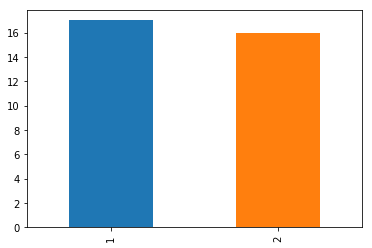

In [28]:
df['price'].dropna().apply(lambda x: len(x)).value_counts().plot(kind='bar')

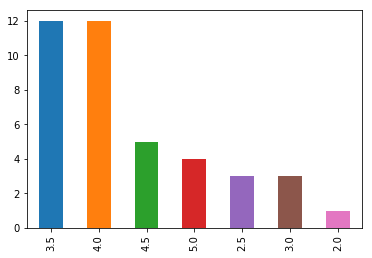

In [29]:
df['rating'].dropna().value_counts().plot(kind='bar')

In [30]:
df.columns

Index(['index', 'alias', 'categories', 'coordinates', 'display_phone',
       'distance', 'id', 'image_url', 'is_closed', 'location', 'name', 'phone',
       'price', 'rating', 'review_count', 'transactions', 'url'],
      dtype='object')

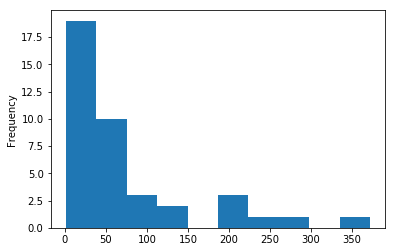

In [31]:
df['review_count'].dropna().plot(kind='hist')

In [32]:
df['price'] = df['price'].fillna(value='$').apply(lambda x: len(x))

In [33]:
df_to_analyze = df.loc[:, ['review_count', 'rating', 'price']].fillna(value=0.0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa22dcfba20>,
      dtype=object)

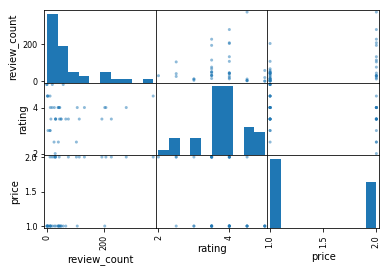

In [34]:
pd.plotting.scatter_matrix(df_to_analyze)

In [35]:
df_to_analyze.corr()

,review_count,rating,price
review_count,1.000000,0.040067,0.472201
rating,0.040067,1.000000,-0.353848
price,0.472201,-0.353848,1.000000


## Mapping

Look at the initial Yelp example and try and make a map using Folium of the restaurants you retrieved. Be sure to also add popups to the markers giving some basic information such as name, rating and price.

In [36]:
import folium
import numpy as np

In [37]:
import ast
ast.literal_eval(df['coordinates'][0])

ValueError: malformed node or string: {'address1': '2329 North 90th St', 'address2': '', 'address3': None, 'city': 'Omaha', 'zip_code': '68134', 'country': 'US', 'state': 'NE', 'display_address': ['2329 North 90th St', 'Omaha, NE 68134']}

In [ ]:
type(ast.literal_eval("{'test':0}"))

In [ ]:
lat = 
long = -0.14

#Create a map of the area
base_map = folium.Map([lat, long], zoom_start=13)

points = list(zip(x, y))
for p in points:
    lat = p[0]
    long = p[1]
    marker = folium.Marker(location=[lat, long])
    marker.add_to(base_map)

for p in points:
    lat = p[0]
    long = p[1]
    popup_text = "Latitude: {}, Longitude: {}".format(lat,long)
    popup = folium.Popup(popup_text, parse_html=True)
    marker = folium.Marker(location=[lat, long], popup=popup)
    marker.add_to(base_map)
base_map

## Summary

Nice work! In this lab, you synthesized your skills for the day, making multiple API calls to Yelp in order to paginate through a results set, performing some basic exploratory analysis and then creating a nice map visual to display the results! Well done!